In [240]:
from utils import *

from random_cycles import gen_random_cycles
from local_search import local_search_steepest, local_search_greedy


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Utils

In [241]:
#import deepcopy pip
import copy
from copy import deepcopy

### Hybrid Evolutionary Algorithm

In [242]:
def gen_initial_population(data, distance_matrix, size):
    start_time = time.time()
    population = []
    for _ in range(size):
        randoms = gen_random_cycles(get_nodes(data))
        local_searched = local_search_greedy(*randoms, distance_matrix, data)
        population.append(local_searched)
    print("Initial population generated in: ", time.time() - start_time)
    return population

In [243]:
def recombine(parent1, parent2, distance_matrix): # crossing over

    edges_in_parent_2 = set()
    for c in parent2:
        for i in range(len(c)):
            edges_in_parent_2.add((c[i], c[(i+1) % len(c)]))

    print("Krawędzie w parent2: ", edges_in_parent_2)

    cycle1 = deepcopy(parent1[0])
    cycle2 = deepcopy(parent1[1])

    print("Długość cyklu 1: ", len(cycle1))
    print("Długość cyklu 2: ", len(cycle2))
    print()

    cycle1_marked = [False] * len(cycle1)
    cycle2_marked = [False] * len(cycle2)

    for i in range(len(cycle1)):
        if (cycle1[i], cycle1[(i+1) % len(cycle1)]) in edges_in_parent_2:
            cycle1_marked[i] = True
            cycle1_marked[(i+1) % len(cycle1)] = True
    
    for i in range(len(cycle2)):
        if (cycle2[i], cycle2[(i+1) % len(cycle2)]) in edges_in_parent_2:
            cycle2_marked[i] = True
            cycle2_marked[(i+1) % len(cycle2)] = True

    free_nodes = []
    for i in range(len(cycle1)):
        if not cycle1_marked[i]:
            free_nodes.append(cycle1[i])
    for i in range(len(cycle2)):
        if not cycle2_marked[i]:
            free_nodes.append(cycle2[i])

    # remove False nodes
    cycle1 = [cycle1[i] for i in range(len(cycle1)) if cycle1_marked[i]]
    cycle2 = [cycle2[i] for i in range(len(cycle2)) if cycle2_marked[i]]

    if len(cycle1) == 0 or len(cycle2) == 0:
        return parent1[0], parent1[1]

    print("Po niszczeniu")
    print("Długość cyklu 1: ", len(cycle1))
    print("Długość cyklu 2: ", len(cycle2))
    print("Długość free_nodes: ", len(free_nodes))
    print("______")

    while len(free_nodes) > 0:
        if len(cycle1) < 100:
            best_update1 = float('inf')
            best_node1 = None
            best_position1 = -1
            
            for node in free_nodes:
                for i in range(len(cycle1)):
                    distance_update = distance_matrix[cycle1[i-1]][node] + distance_matrix[node][cycle1[i]] - distance_matrix[cycle1[i-1]][cycle1[i]]
                    if distance_update < best_update1:
                        best_update1 = distance_update
                        best_node1 = node
                        best_position1 = i
            
            if best_node1 is not None:
                cycle1.insert(best_position1, best_node1)
                free_nodes.remove(best_node1)

        if len(cycle2) < 100:
            best_update2 = float('inf')
            best_node2 = None
            best_position2 = -1
            
            for node in free_nodes:
                for i in range(len(cycle2)):
                    distance_update = distance_matrix[cycle2[i-1]][node] + distance_matrix[node][cycle2[i]] - distance_matrix[cycle2[i-1]][cycle2[i]]
                    if distance_update < best_update2:
                        best_update2 = distance_update
                        best_node2 = node
                        best_position2 = i
            
            if best_node2 is not None:
                cycle2.insert(best_position2, best_node2)
                free_nodes.remove(best_node2)

    print("Po odbudowie")
    print("Długość cyklu 1: ", len(cycle1))
    print("Długość cyklu 2: ", len(cycle2))
    print("Długość free_nodes: ", len(free_nodes))
    print("______")

    return cycle1, cycle2

In [244]:
def hybrid_evolutionary_algorithm(distance_matrix, data, population_size, num_generations):
    population = gen_initial_population(data, distance_matrix, population_size)
    
    for _ in range(num_generations):
        
        parent_indices = np.random.choice(len(population), 2, replace=False)
        parent1, parent2 = population[parent_indices[0]], population[parent_indices[1]]
                
        offspring = recombine(parent1, parent2, distance_matrix)
        # offspring = local_search_steepest(*offspring, distance_matrix, data)
        
        worst_index = np.argmax([calculate_cycles_length(*ind, distance_matrix) for ind in population])
        worst_length = calculate_cycles_length(*population[worst_index], distance_matrix)

        offspring_length = calculate_cycles_length(*offspring, distance_matrix)
        
        if offspring_length < worst_length: # and is_diverse(offspring, population):
            population[worst_index] = offspring
    
    best_index = np.argmin([calculate_cycles_length(*ind, distance_matrix) for ind in population])
    return population[best_index]



def is_diverse(individual, population, threshold=0.1):
    individual_length = calculate_cycles_length(*individual, distance_matrix)
    for other in population:
        other_length = calculate_cycles_length(*other, distance_matrix)
        if abs(individual_length - other_length) < threshold * individual_length:
            return False
    return True

### Run

In [245]:
FILENAME = 'data/kroB200.tsp'
VISUALIZE = False
num_of_runs = 1

In [246]:
data = read_data_file(FILENAME)
distance_matrix = calculate_distance_matrix(data)

In [247]:
best_cycle_1, best_cycle_2 = hybrid_evolutionary_algorithm(
    distance_matrix,
    data,
    population_size=20,
    num_generations=100
    )


Initial population generated in:  145.40700006484985
Krawędzie w parent2:  {(150, 75), (198, 39), (116, 52), (1, 95), (80, 65), (124, 184), (121, 48), (90, 161), (164, 55), (172, 157), (134, 30), (20, 38), (85, 73), (73, 53), (132, 5), (79, 188), (19, 137), (66, 133), (6, 112), (141, 47), (194, 117), (28, 158), (89, 43), (157, 180), (130, 44), (44, 102), (182, 118), (35, 172), (37, 72), (17, 78), (174, 98), (76, 136), (26, 62), (114, 74), (15, 89), (200, 92), (111, 69), (64, 82), (48, 31), (57, 34), (163, 116), (199, 145), (154, 177), (5, 197), (162, 135), (54, 163), (183, 103), (185, 164), (160, 153), (50, 159), (87, 4), (99, 97), (96, 119), (95, 29), (70, 198), (22, 23), (119, 148), (2, 109), (197, 67), (133, 168), (122, 85), (93, 122), (127, 124), (45, 18), (34, 146), (186, 60), (189, 111), (92, 151), (175, 167), (136, 59), (55, 104), (61, 35), (33, 83), (49, 134), (143, 171), (36, 45), (161, 12), (59, 175), (146, 152), (31, 195), (97, 76), (94, 178), (51, 63), (102, 200), (13, 110)

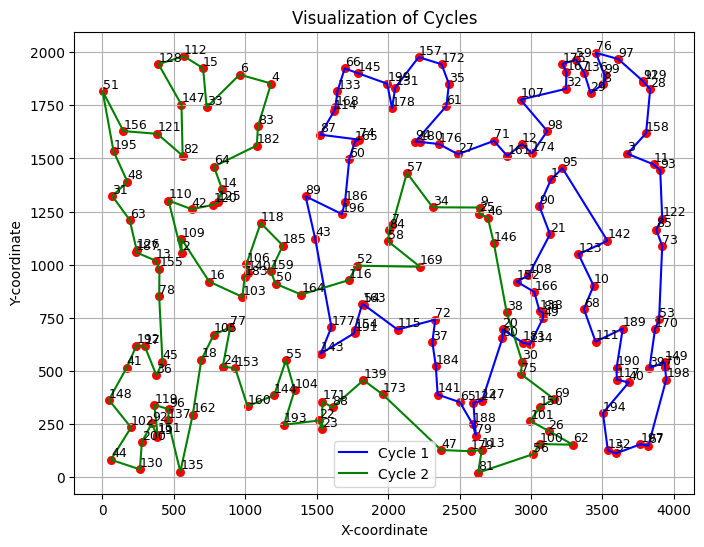

31301.55294184145

In [248]:
plot_cycles(best_cycle_1, best_cycle_2, data)
calculate_cycles_length(best_cycle_1, best_cycle_2, distance_matrix)